In [ ]:
!pip install torch torchvision albumentations opencv-python matplotlib


import os
import random
import math
import time
import copy
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms
from torchvision.utils import make_grid
import cv2
import matplotlib.pyplot as plt

# Cấu hình hiển thị matplotlib
plt.rcParams['figure.figsize'] = (6, 4)


def set_seed(s=42):
    random.seed(s)
    np.random.seed(s)
    torch.manual_seed(s)
    torch.cuda.manual_seed_all(s)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False



device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device:", device)


def imshow(img, title=None):
    if torch.is_tensor(img):
        img = img.detach().cpu().numpy().transpose(1, 2, 0)
    plt.imshow(np.clip(img, 0, 1))
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()


Device: cpu


In [ ]:
from torchvision.datasets import OxfordIIITPet
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torch
import random
import os

# ----------------------
# ĐƯỜNG DẪN DỮ LIỆU
# ----------------------
root = "./data/pets"
os.makedirs(root, exist_ok=True)

# ----------------------
# BIẾN ĐỔI ẢNH & MASK
# ----------------------
tfm_img = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

tfm_mask = transforms.Compose([
    transforms.Resize((256, 256), interpolation=transforms.InterpolationMode.NEAREST),
    transforms.PILToTensor(),  # giữ mask dạng [1,H,W] với giá trị class-id
])

# ----------------------
# CUSTOM DATASET
# ----------------------
class PetSeg(Dataset):
    def __init__(self, train=True):
        split = 'trainval' if train else 'test'
        self.base = OxfordIIITPet(
            root=root,
            split=split,
            target_types='segmentation',
            download=True
        )

        # Tách train/test đơn giản (85% train, 15% val)
        n = len(self.base)
        idx = list(range(n))
        random.seed(0)
        random.shuffle(idx)
        cut = int(0.85 * n)
        self.ids = idx[:cut] if train else idx[cut:]

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, i):
        img, mask = self.base[self.ids[i]]

        # Biến đổi ảnh và mask
        img = tfm_img(img)
        m = tfm_mask(mask).squeeze(0)  # [H,W]

        # mask có giá trị {1, 2, 3}: background/border/object
        # Chuẩn hóa về nhị phân {0, 1}
        m = (m > 1).long()  # object (>1) là 1, còn lại 0

        return img, m

# ----------------------
# TẠO DATASET VÀ DATALOADER
# ----------------------
train_ds = PetSeg(train=True)
val_ds = PetSeg(train=False)

train_loader = DataLoader(train_ds, batch_size=8, shuffle=True,
                          num_workers=0, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=8, shuffle=False,
                        num_workers=0, pin_memory=True)

# ----------------------
# KIỂM TRA MỘT BATCH
# ----------------------
imgs, msks = next(iter(train_loader))
print("Batch:", imgs.shape, msks.shape, msks.unique())


100%|██████████| 792M/792M [00:24<00:00, 33.0MB/s]
100%|██████████| 19.2M/19.2M [00:01<00:00, 16.3MB/s]
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Batch: torch.Size([8, 3, 256, 256]) torch.Size([8, 256, 256]) tensor([0, 1])


Using device: cpu


Training: 100%|██████████| 5/5 [00:18<00:00,  3.74s/it]


[DeepLabV3-10imgs] Epoch 1: loss=1.6419, mIoU=0.6574


Training: 100%|██████████| 5/5 [00:16<00:00,  3.36s/it]


[DeepLabV3-10imgs] Epoch 2: loss=1.4413, mIoU=0.6728


Training: 100%|██████████| 5/5 [00:15<00:00,  3.20s/it]


[DeepLabV3-10imgs] Epoch 3: loss=1.2414, mIoU=0.7491
✅ Model saved to /content/checkpoints/deeplabv3_pet_10imgs.pth


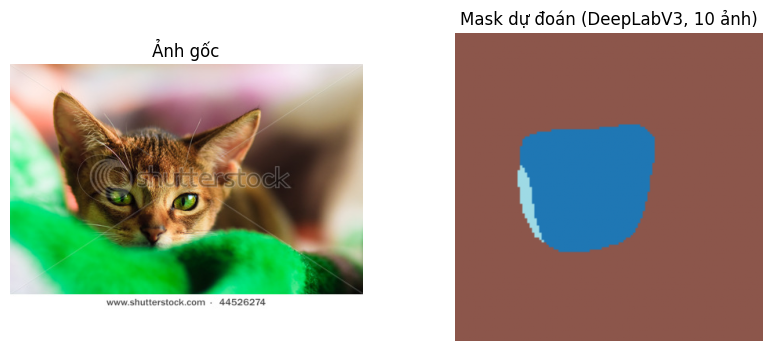

In [ ]:
# =======================================================
# DeepLabV3 (ResNet50) — Demo 10 ảnh Oxford-IIIT Pet
# =======================================================
import torch, torch.nn as nn, torch.nn.functional as F
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import os, numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Using device:", device)


class OxfordPetSegDataset(Dataset):
    def __init__(self, root, image_set="train", img_size=128, limit=10):
        self.img_dir = os.path.join(root, "images")
        self.mask_dir = os.path.join(root, "annotations/trimaps")
        self.files = [f[:-4] for f in os.listdir(self.img_dir) if f.endswith(".jpg")]
        self.files = sorted(self.files)[:limit]  # chỉ lấy 10 ảnh đầu tiên

        self.img_transform = transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.ToTensor(),
        ])
        self.mask_transform = transforms.Compose([
            transforms.Resize((img_size, img_size), interpolation=Image.NEAREST)
        ])

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        name = self.files[idx]
        img = Image.open(os.path.join(self.img_dir, name + ".jpg")).convert("RGB")
        mask = Image.open(os.path.join(self.mask_dir, name + ".png"))
        img = self.img_transform(img)
        mask = self.mask_transform(mask)
        mask = torch.from_numpy(np.array(mask, dtype=np.int64) - 1)  # {1,2,3} -> {0,1,2}
        return img, mask


root = "/content/data/pets/oxford-iiit-pet"
train_dataset = OxfordPetSegDataset(root, "train", img_size=128, limit=10)
val_dataset = OxfordPetSegDataset(root, "val", img_size=128, limit=10)
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False)

n_classes = 3


def dice_loss(pred, target, smooth=1e-5):
    pred = F.softmax(pred, dim=1)
    target_onehot = F.one_hot(target, num_classes=pred.shape[1]).permute(0,3,1,2)
    inter = (pred * target_onehot).sum(dim=(2,3))
    union = pred.sum(dim=(2,3)) + target_onehot.sum(dim=(2,3))
    dice = (2 * inter + smooth) / (union + smooth)
    return 1 - dice.mean()



model = torchvision.models.segmentation.deeplabv3_resnet50(weights='DEFAULT')
model.classifier[-1] = nn.Conv2d(256, n_classes, 1)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)

def forward_seg(x): return model(x)['out']


def train_epoch(model, loader, opt):
    model.train()
    total_loss = 0
    for imgs, masks in tqdm(loader, desc="Training"):
        imgs, masks = imgs.to(device), masks.to(device)
        out = forward_seg(imgs)
        loss = F.cross_entropy(out, masks) + dice_loss(out, masks)
        opt.zero_grad(); loss.backward(); opt.step()
        total_loss += loss.item()
    return total_loss / len(loader)

def evaluate(model, loader):
    model.eval()
    total_iou = 0
    with torch.no_grad():
        for imgs, masks in loader:
            imgs, masks = imgs.to(device), masks.to(device)
            out = forward_seg(imgs)
            preds = torch.argmax(out, dim=1)
            inter = ((preds == masks) & (masks > 0)).sum().float()
            union = ((preds > 0) | (masks > 0)).sum().float()
            total_iou += (inter / (union + 1e-6)).item()
    return total_iou / len(loader)



save_path = "/content/checkpoints/deeplabv3_pet_10imgs.pth"
os.makedirs(os.path.dirname(save_path), exist_ok=True)

for epoch in range(3):
    tr = train_epoch(model, train_loader, optimizer)
    va = evaluate(model, val_loader)
    print(f"[DeepLabV3-10imgs] Epoch {epoch+1}: loss={tr:.4f}, mIoU={va:.4f}")

torch.save(model.state_dict(), save_path)
print(f"✅ Model saved to {save_path}")


model.load_state_dict(torch.load(save_path, map_location=device))
model.eval()

test_img = "/content/data/pets/oxford-iiit-pet/images/Abyssinian_101.jpg"
img = Image.open(test_img).convert("RGB")
img_t = transforms.Compose([transforms.Resize((128, 128)), transforms.ToTensor()])(img).unsqueeze(0).to(device)

with torch.no_grad():
    out = model(img_t)['out']
    pred = torch.argmax(out, dim=1).squeeze().cpu().numpy()


plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(img)
plt.title("Ảnh gốc"); plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(pred, cmap='tab20')
plt.title("Mask dự đoán (DeepLabV3, 10 ảnh)"); plt.axis("off")
plt.show()


Device: cpu
Đang tải mô hình SegFormer...
Đang xử lý 10 ảnh...
[1/10] Abyssinian_1.jpg
[2/10] Abyssinian_10.jpg
[3/10] Abyssinian_100.jpg
[4/10] Abyssinian_101.jpg
[5/10] Abyssinian_102.jpg
[6/10] Abyssinian_103.jpg
[7/10] Abyssinian_104.jpg
[8/10] Abyssinian_105.jpg
[9/10] Abyssinian_106.jpg
[10/10] Abyssinian_107.jpg
Hoàn thành inference!


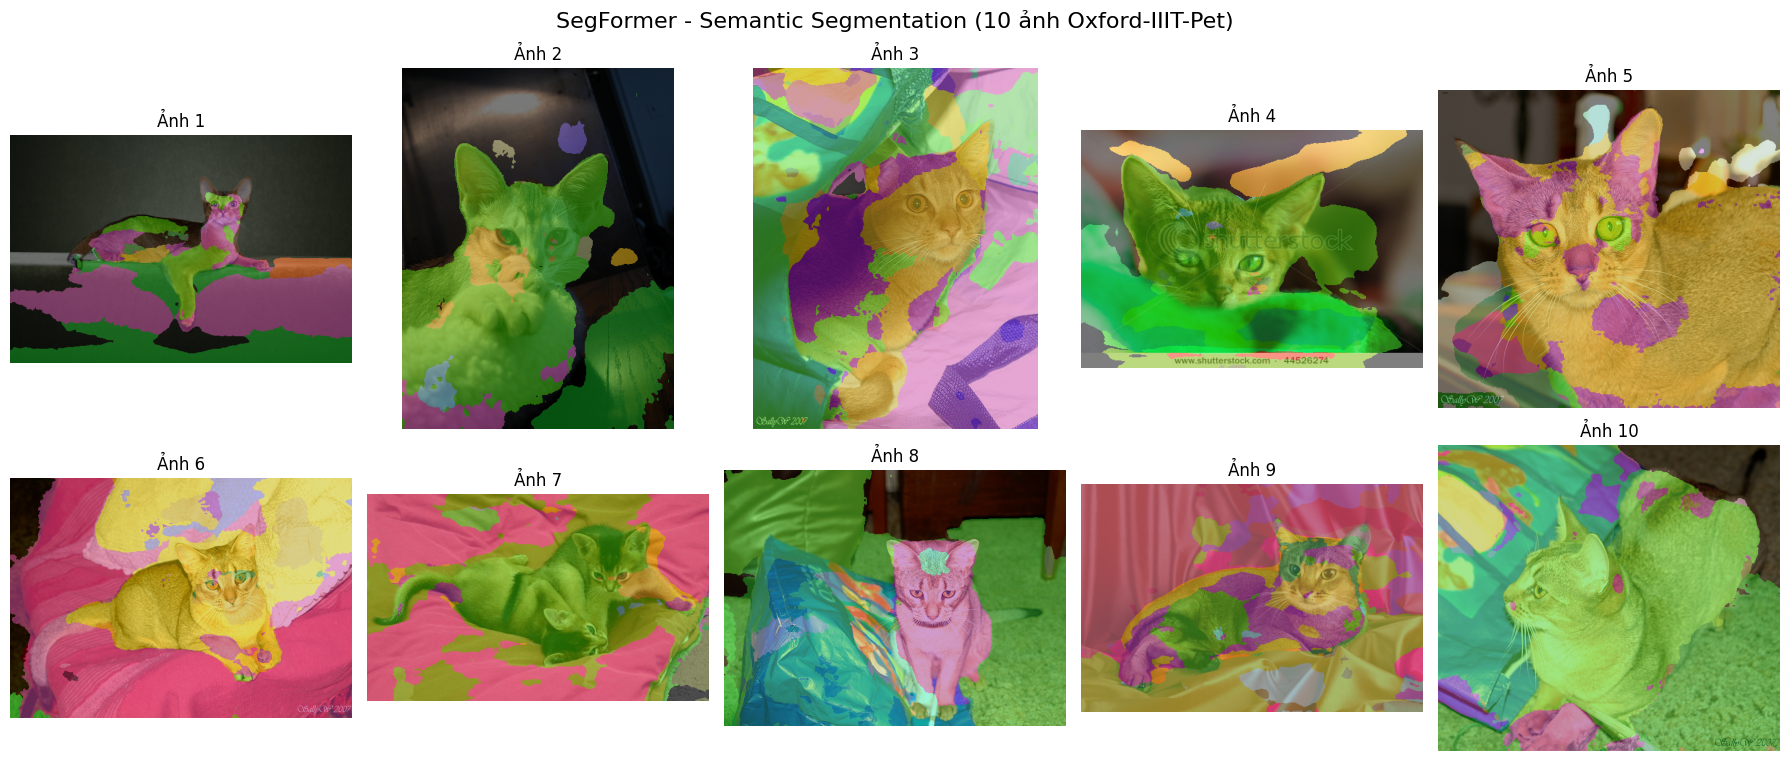

In [ ]:
# ==============================================================
# SegFormer Semantic Segmentation — hiển thị 10 ảnh
# ==============================================================

import os, json, cv2, numpy as np, torch, matplotlib.pyplot as plt
from glob import glob

# ----------------- Cấu hình -----------------
CKPT = "nvidia/segformer-b0-finetuned-ade-512-512"
DATA_DIR = "/content/data/pets/oxford-iiit-pet/images"
OUT_DIR = "outputs_segformer_pets"
NUM_IMAGES = 10  # số ảnh muốn hiển thị
ALPHA = 0.5
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

os.makedirs(OUT_DIR, exist_ok=True)
print(f"Device: {DEVICE}")

# ----------------- Import model -----------------
try:
    from transformers import AutoImageProcessor
    use_auto = True
except Exception:
    from transformers import SegformerFeatureExtractor as AutoImageProcessor
    use_auto = False
from transformers import SegformerForSemanticSegmentation

# ----------------- Tải model -----------------
print("Đang tải mô hình SegFormer...")
processor = AutoImageProcessor.from_pretrained(CKPT)
model = SegformerForSemanticSegmentation.from_pretrained(CKPT).to(DEVICE).eval()

# ----------------- Bảng màu -----------------
num_labels = int(model.config.num_labels)
rng = np.random.default_rng(0)
palette = np.zeros((num_labels, 3), dtype=np.uint8)
palette[0] = [0, 0, 0]
if num_labels > 1:
    palette[1:] = rng.integers(0, 256, size=(num_labels - 1, 3), endpoint=False, dtype=np.uint8)

# ----------------- Hàm dự đoán -----------------
def predict_segformer(image_path):
    img_bgr = cv2.imread(image_path)
    if img_bgr is None:
        print(f"⚠️ Không đọc được ảnh: {image_path}")
        return None
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    H, W = img_rgb.shape[:2]

    # Tiền xử lý
    inputs = processor(images=img_rgb, return_tensors="pt")
    inputs = {k: v.to(DEVICE) for k, v in inputs.items()}

    with torch.no_grad():
        logits = model(**inputs).logits.detach().cpu()

    # Upsample
    up = torch.nn.functional.interpolate(
        logits, size=(H, W), mode="bilinear", align_corners=False
    )
    seg = up.argmax(dim=1)[0].numpy().astype(np.uint16)
    seg_color = palette[seg]
    overlay = ((1 - ALPHA) * img_rgb + ALPHA * seg_color).clip(0, 255).astype(np.uint8)
    return img_rgb, overlay

# ----------------- Chạy inference -----------------
image_paths = sorted(glob(os.path.join(DATA_DIR, "*.jpg")))[:NUM_IMAGES]
print(f"Đang xử lý {len(image_paths)} ảnh...")

results = []
for i, path in enumerate(image_paths, 1):
    print(f"[{i}/{len(image_paths)}] {os.path.basename(path)}")
    img, overlay = predict_segformer(path)
    results.append((img, overlay))

print("Hoàn thành inference!")

# ----------------- Hiển thị 10 ảnh -----------------
n = len(results)
cols = 5
rows = (n + cols - 1) // cols

plt.figure(figsize=(18, 8))
for i, (img, overlay) in enumerate(results):
    plt.subplot(2, cols, i + 1)
    plt.imshow(overlay)
    plt.title(f"Ảnh {i+1}")
    plt.axis("off")

plt.suptitle("SegFormer - Semantic Segmentation (10 ảnh Oxford-IIIT-Pet)", fontsize=16)
plt.tight_layout()
plt.show()
